In [2]:
from pr2_utils import *
import cv2
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
dataset = 20
odo_str = "icp"

with np.load(f"../data/Hokuyo{dataset}.npz") as data:
    lidar_ranges = data["ranges"].T       # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamps = data["time_stamps"]  # acquisition times of the lidar scans

with np.load(f"../data/odometry_{odo_str}_{dataset}.npz") as data:
    odometry = data["X"]
    odometry_stamp = data["stamps"]

f_odometry = InterpN1D(odometry_stamp, odometry)

In [8]:
map_resolution = 10
map_size = (np.ceil((np.max(odometry, axis=0)-np.min(odometry, axis=0))[:2] + lidar_range_max)).astype(int)[::-1] * map_resolution 
map_center= (np.ceil(-np.min(odometry, axis=0)[:2] + 0.5*lidar_range_max)).astype(int)[::-1] * map_resolution

map_size, map_center

(array([540, 510]), array([260, 250]))

In [9]:
occupancy_map = np.zeros(map_size, dtype=int)
# bar = tqdm(range(0,100))
bar= tqdm(range(lidar_stamps.shape[0]))
for i in bar:
    odo = f_odometry(lidar_stamps[i])
    point_cloud = lidar_scan_to_3dpc(lidar_ranges[i])
    wTo = odometry_to_transformation(odo)
    r, t = get_Rt(wTo)
    point_cloud_world = (r @ point_cloud.T).T + t
    point_cloud_map = map_resolution*point_cloud_world[:,:2] + map_center

    lines = []
    for point in point_cloud_map.astype(int):
        sx, sy = (map_resolution*odo[:2]+ map_center).astype(int)
        ex, ey = point.astype(int)
        lines.append(bresenham2D(sx, sy, ex, ey).T.astype(int))
    empty_points = np.unique(np.vstack(lines), axis=0, return_index=False)
    mask = (0 <= empty_points[:, 0]) & (empty_points[:, 0] < occupancy_map.shape[1]) & \
        (0 <= empty_points[:, 1]) & (empty_points[:, 1] < occupancy_map.shape[0])
    filtered_points = empty_points[mask]
    occupancy_map[filtered_points[:, 1], filtered_points[:, 0]] -= 2
    # occupancy_map[unique_empty_points[:,1], unique_empty_points[:,0]] -= 4

    endpoints = point_cloud_map.astype(int)
    endpoint_mask = (0 <= endpoints[:, 0]) & (endpoints[:, 0] < occupancy_map.shape[1]) & \
                    (0 <= endpoints[:, 1]) & (endpoints[:, 1] < occupancy_map.shape[0])
    filtered_endpoints = endpoints[endpoint_mask]
    occupancy_map[filtered_endpoints[:, 1], filtered_endpoints[:, 0]] += 6
    # occupancy_map[endpoints[:, 1], endpoints[:, 0]] += 8

100%|██████████| 4962/4962 [01:56<00:00, 42.44it/s]


(4962, 2)


/tmp/ipykernel_10270/1286507415.py:1: RuntimeWarning: overflow encountered in exp
  probability_map = 1 / (1 + np.exp(-occupancy_map, dtype=np.float64))


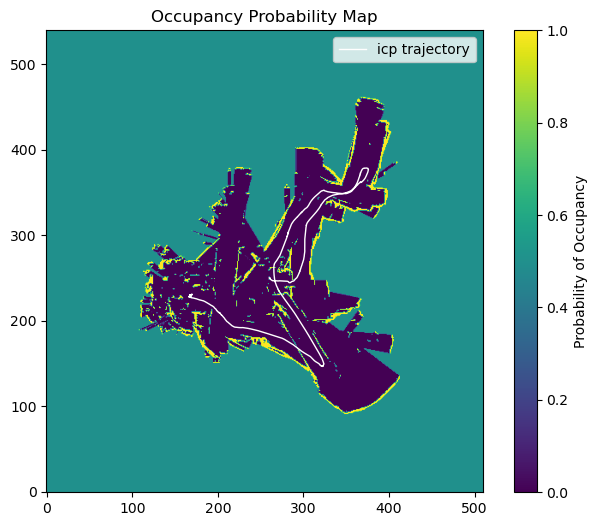

In [13]:
probability_map = 1 / (1 + np.exp(-occupancy_map, dtype=np.float64))
# Plotting
plt.figure(figsize=(8, 6))
plt.imshow(probability_map, cmap='viridis', origin='lower')
# plt.plot(odometry_map)
plt.colorbar(label='Probability of Occupancy')
plt.title('Occupancy Probability Map')

odometry_map = map_resolution*odometry[:,:2] + map_center
print(odometry_map.shape)
plt.plot(odometry_map[:,0], odometry_map[:,1], color='white', linewidth=1, label=f'{odo_str} trajectory')
plt.legend()
plt.show()

# texture mapping

using disp time stamp as the standard time

In [5]:
with np.load("../data/Kinect%d.npz"%dataset) as data:
    disp_stamps = data["disparity_time_stamps"] # acquisition times of the disparity images
    rgb_stamps = data["rgb_time_stamps"] # acquisition times of the rgb images

f_rgb = interp1d(rgb_stamps, np.arange(1, rgb_stamps.shape[0]+1), 
                 kind='nearest', fill_value=(1, rgb_stamps.shape[0]))

In [6]:
def uvd_to_3d(uvd):
    '''
    Convert 2D pixel coordinates and depth to 3D coordinates.
    
    Parameters:
    - uvd: np.array with shape (n, 3)
        - u: np.array with shape (n,)
        - v: np.array with shape (n,)
        - d: np.array with shape (n,)
    
    Returns:
    - A numpy array of shape (n, 3) representing 3D coordinates for each input pixel in body frame
    '''    
    # Inverse camera projection
    fu, fv, cu, cv = 585.05, 585.05, 242.94, 315
    X_c = (uvd[:,0] - cu) / fu * uvd[:,2]
    Y_c = (uvd[:,1] - cv) / fv * uvd[:,2]
    Z_c = uvd[:,2]
    
    # Combine into a single matrix
    points_camera_frame = np.vstack((X_c, Y_c, Z_c)).T
    
    # Camera orientation and position in robot center frame
    roll, pitch, yaw = 0, 0.36, 0.021
    R_pitch = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                        [0, 1, 0],
                        [-np.sin(pitch), 0, np.cos(pitch)]])
    R_yaw = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                      [np.sin(yaw), np.cos(yaw), 0],
                      [0, 0, 1]])
    # Assuming roll is 0, we omit its rotation matrix for simplicity
    R = R_yaw @ R_pitch
    t = np.array([0.18, 0.005, 0.36])
    
    # Transform points to robot center frame
    Ro = np.array([
        [ 0,  0,  1 ],
        [ 0,  1,  0 ],
        [ -1,  0,  0 ]])
    points_robot_center_frame = (points_camera_frame @ R.T + t)@Ro.T

    return points_robot_center_frame

def dimg_to_uvd(d_img, step=1, d_max = 1088):
    '''
    input: d_img the disparity image
    return: (u,v,d) tuples
    '''
    # Create a meshgrid of pixel coordinates
    m, n = d_img.shape
    u, v = np.meshgrid(np.arange(0,m,step), np.arange(0,n,step), indexing='ij')
    u, v = u.flatten(), v.flatten()
    d = d_img[u, v]
    mask = d < d_max
    dd = 1.03/(-0.00304*d[mask] + 3.31)
    uvd = np.vstack((u[mask], v[mask], dd)).T
    return uvd

def get_rgb_uv(uvd):
    '''
    input: [u, v, d] the disparity image
    return: the pixel location (rgbi, rgbj)
    '''
    dd  = -0.00304*uvd[:,2] + 3.31
    rgbu = (526.37*uvd[:,0] + 19276 - 7877.07*dd)/585.051
    rgbv = (526.37*uvd[:,1] + 16662)/585.051
    return np.stack([rgbu, rgbv], axis=-1).astype(int)


def visualize_points(points, colors):
    """
    Visualize 3D points with colors using Open3D.
    
    Parameters:
    - points: np.array of shape (n, 3), where n is the number of points.
    - colors: np.array of shape (n, 3), representing RGB colors normalized between 0 and 1.
    """
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors/255)
    coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=5, origin=[0,0,0])
    o3d.visualization.draw_geometries([pcd, coordinate_frame])

In [7]:
def build_3dpc(d_img, rgb_img):
    uvd = dimg_to_uvd(d_img, 4)
    rgb_uv = get_rgb_uv(uvd)
    mask =  (0 <= rgb_uv[:,0]) &  (rgb_uv[:,0] < rgb_img.shape[0]) & \
            (0 <= rgb_uv[:,1]) &  (rgb_uv[:,1] < rgb_img.shape[1])
    coord = uvd_to_3d(uvd[mask])
    rgb = rgb_img[rgb_uv[mask][:,0], rgb_uv[mask][:,1]]
    return coord, rgb

In [8]:
all_coord = []
all_rgb = []

# bar = tqdm(range(1000,1001))
bar = tqdm(range(1, disp_stamps.shape[0], 2))
for disp_index in bar:
    d_path = f"../data/dataRGBD/Disparity{dataset}/disparity{dataset}_{disp_index}.png"
    d_img = cv2.imread(d_path, cv2.IMREAD_UNCHANGED)
    try:
        rgb_index = int(f_rgb(disp_stamps[disp_index]))
    except ValueError:
        continue
    rgb_path = f"../data/dataRGBD/RGB{dataset}/rgb{dataset}_{rgb_index}.png"
    rgb_img = cv2.imread(rgb_path, cv2.IMREAD_UNCHANGED)

    coord_body, rgb = build_3dpc(d_img, rgb_img)
    T = odometry_to_transformation( f_odometry(disp_stamps[disp_index]) )
    R, t = get_Rt(T)
    coord_world = (coord_body @ R.T) + t
    all_coord.append(coord_world)
    all_rgb.append(rgb)

visualize_points(np.concatenate(all_coord), np.concatenate(all_rgb))

  0%|          | 0/1203 [00:00<?, ?it/s]

100%|██████████| 1203/1203 [00:12<00:00, 99.84it/s] 


(480, 640, 3)


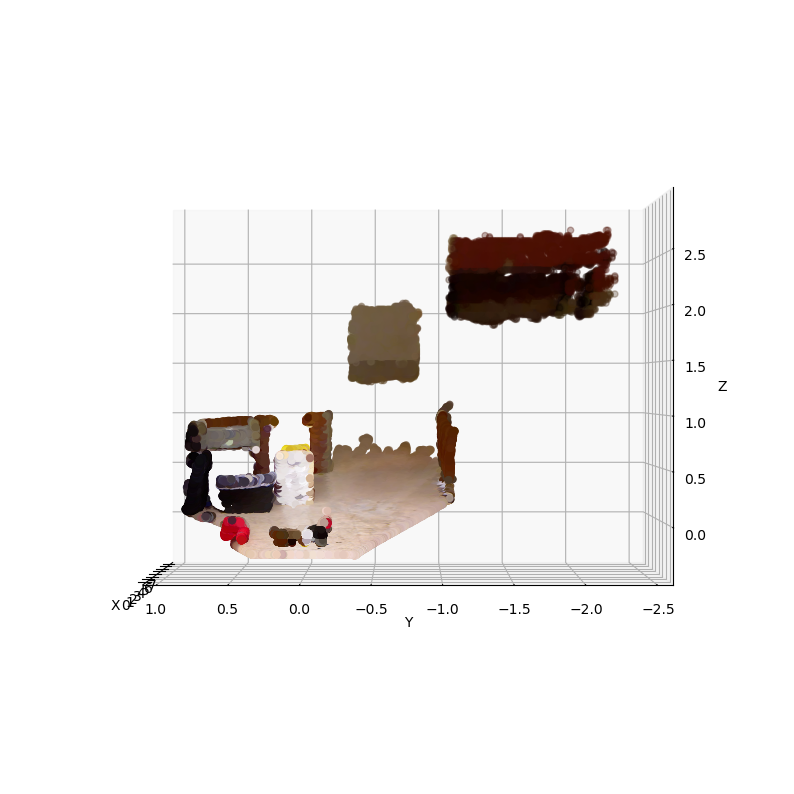

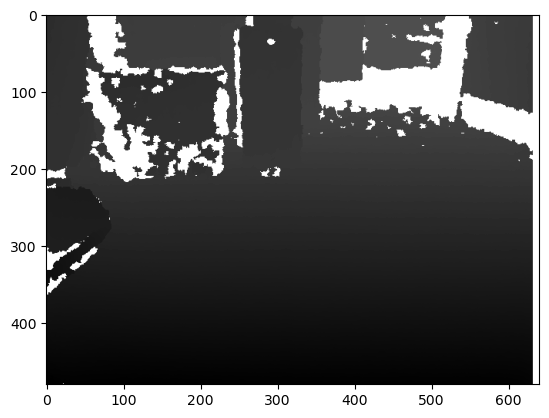

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

disp_path = "../data/dataRGBD/Disparity20/"
rgb_path = "../data/dataRGBD/RGB20/"

def normalize(img):
    max_ = img.max()
    min_ = img.min()
    return (img - min_)/(max_-min_)



# load RGBD image
imd = cv2.imread(disp_path+'disparity20_1.png',cv2.IMREAD_UNCHANGED) # (480 x 640)
imc = cv2.imread(rgb_path+'rgb20_1.png')[...,::-1] # (480 x 640 x 3)

print(imc.shape)

# convert from disparity from uint16 to double
disparity = imd.astype(np.float32)

# get depth
dd = (-0.00304 * disparity + 3.31)
z = 1.03 / dd

# calculate u and v coordinates 
v,u = np.mgrid[0:disparity.shape[0],0:disparity.shape[1]]
#u,v = np.meshgrid(np.arange(disparity.shape[1]),np.arange(disparity.shape[0]))

# get 3D coordinates 
fx = 585.05108211
fy = 585.05108211
cx = 315.83800193
cy = 242.94140713
x = (u-cx) / fx * z
y = (v-cy) / fy * z

# calculate the location of each pixel in the RGB image
rgbu = np.round((u * 526.37 + dd*(-4.5*1750.46) + 19276.0)/fx)
rgbv = np.round((v * 526.37 + 16662.0)/fy)
valid = (rgbu>= 0)&(rgbu < disparity.shape[1])&(rgbv>=0)&(rgbv<disparity.shape[0])

# display valid RGB pixels
fig = plt.figure(figsize=(10, 13.3))
ax = fig.add_subplot(projection='3d')
ax.scatter(z[valid],-x[valid],-y[valid],c=imc[rgbv[valid].astype(int),rgbu[valid].astype(int)]/255.0)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=0, azim=180)
plt.show()

# display disparity image
plt.imshow(normalize(imd), cmap='gray')
plt.show()